In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

import pycollocation

import inputs
import models
import shooting

# Example: 

## Worker skill and firm productivity are $\sim U[a, b]$...

In [5]:
# define some workers skill
x, a, b = sym.var('x, a, b')
skill_cdf = (x - a) / (b - a)
skill_params = {'a': 1.0, 'b': 2.0}
skill_bounds = [skill_params['a'], skill_params['b']]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some firms
y = sym.var('y')
productivity_cdf = (y - a) / (b - a)
productivity_params = skill_params
productivity_bounds = skill_bounds

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

## ...and production function is multiplicatively separable.
A particularly attractive case arises under multiplicative separability of the form

$$F(x, y, l, r) = A(x, y)B(l, r)$$

In this case the condition for positive assortative matching can be written as 

$$\frac{AA_{xy}}{A_xA_y}\frac{BB_{lr}}{B_lB_r} \ge 1$$

If $B$ has constant elasticity of substitution form, then we obtain an even simpler condition

$$\frac{AA_{xy}}{A_xA_y} \frac{1}{\sigma_{lr}}\ge 1$$

where $\sigma_{lr}$ is the elasticity of substitution between $l$ and $r$. 

Finally, if $A$ also has constant elasticity of substitution form, then we obtain an even simpler condition

$$\frac{1}{\sigma_{xy}\sigma_{lr}}\ge 1 \iff \sigma_{xy}\sigma_{lr} \le 1$$

where $\sigma_{xy}$ is the elasticity of substitution between $x$ and $y$.

In [6]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for Cobb-Douglas between l and r
l, r, omega_B, sigma_B = sym.var('l, r, omega_B, sigma_B')
B = l**omega_B * r**(1 - omega_B)

F = A * B

Create an instance of the `models.Model` class and an instance of the `solvers.ShootingSolver` class...

### Positive assortative matching

In [108]:
F_params = {'omega_A':0.75, 'omega_B':0.25, 'sigma_A':0.5, 'sigma_B':1.0}

model = models.Model(assortativity='positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

In [109]:
mu, theta = sym.symbols('mu, theta')
rhs = {mu: model.matching.mu_prime, theta: model.matching.theta_prime}

# specify some boundary conditions
bcs = {'lower': [mu - workers.lower], 'upper': [mu - workers.upper]}

model2 = pycollocation.BoundaryValueProblem(dependent_vars=[mu, theta],
                                            independent_var=x,
                                            rhs=rhs,
                                            boundary_conditions=bcs)

In [110]:
# set the solver instance
solver = pycollocation.OrthogonalPolynomialSolver(model2, model.params)

# set the domain
domain = [workers.lower, workers.upper]

# set an initial guess
xs = np.linspace(domain[0], domain[1], 1000)
e = ((firms.upper - firms.lower) / (workers.upper**0.5 - workers.lower**0.5))
d = firms.lower - e * workers.lower**0.5
mus = d + e * xs**0.5
initial_guess_mu = np.polynomial.Chebyshev.fit(xs, mus, 13, domain)

thetas = (1 / initial_guess_mu.deriv()(xs)) # only works for uniform!
initial_guess_theta = np.polynomial.Chebyshev.fit(xs, thetas, 13, domain)

initial_coefs = {mu: initial_guess_mu.coef, theta: initial_guess_theta.coef}

In [111]:
solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain)
solution = pycollocation.Solution(solver)

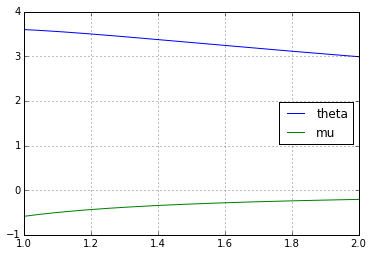

In [112]:
solution.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
solution.residuals.plot()

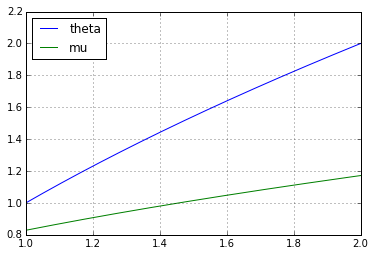

In [113]:
solution.solution.plot()

In [183]:
solver.solve(2e0, tol=1e-6, number_knots=1000, integrator='dopri5',
             atol=1e-12, rtol=1e-9, message=True)

Exhausted firms: initial guess of 1.0 for firm size is too low.
Exhausted workers: initial guess of 1.5 for firm size is too high!
Exhausted firms: initial guess of 1.25 for firm size is too low.
Exhausted firms: initial guess of 1.375 for firm size is too low.
Exhausted workers: initial guess of 1.4375 for firm size is too high!
Exhausted firms: initial guess of 1.40625 for firm size is too low.
Exhausted workers: initial guess of 1.421875 for firm size is too high!
Exhausted workers: initial guess of 1.4140625 for firm size is too high!
Exhausted workers: initial guess of 1.41015625 for firm size is too high!
Exhausted workers: initial guess of 1.408203125 for firm size is too high!
Exhausted firms: initial guess of 1.4072265625 for firm size was too low!
Exhausted firms: initial guess of 1.40771484375 for firm size was too low!
Exhausted firms: initial guess of 1.40795898438 for firm size was too low!
Exhausted firms: initial guess of 1.40808105469 for firm size was too low!
Exhaust

In [184]:
solver.solution.head()

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
1.000000,1.000001,0.560181,0.866920,0.161878
1.001001,1.001785,0.561807,0.867499,0.162456
1.002002,1.003564,0.563429,0.868077,0.163033
1.003003,1.005338,0.565046,0.868655,0.163610
1.004004,1.007107,0.566660,0.869233,0.164186


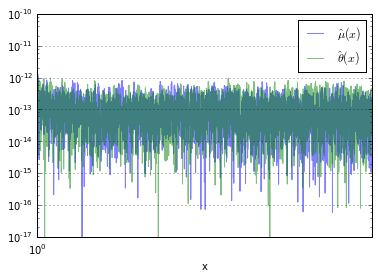

In [185]:
solver.residuals.plot(loglog=True, alpha=0.5)

In [188]:
x = solver.solution.index.values
mu = solver.solution[r'$\mu(x)$'].values
theta = solver.solution[r'$\theta(x)$'].values

colloc_solver = collocation.OrthogonalCollocation(model=model)
colloc_solver.degree_mu = 20
colloc_solver.degree_theta = 20
initial_guess_mu = colloc_solver.orthogonal_polynomial_mu.fit(x, mu, 20)
initial_guess_theta = colloc_solver.orthogonal_polynomial_theta.fit(x, theta, 20)

In [189]:
initial_guess = np.hstack((initial_guess_mu.coef, initial_guess_theta.coef))
colloc_solver.solve(initial_guess)

  status: 1
 success: True
     qtf: array([  1.12547653e-08,  -4.36398211e-09,   1.18046087e-09,
        -1.76982023e-09,   7.13563631e-10,  -1.65520773e-10,
         3.08329016e-09,  -1.61925453e-09,  -7.49199829e-10,
        -3.23434973e-09,   1.59132566e-09,  -1.08614062e-09,
         1.74461771e-09,  -9.37382542e-10,  -2.71888464e-10,
        -1.21176142e-09,   1.47240186e-09,  -1.91956863e-09,
        -9.14681679e-10,   3.87918348e-09,  -1.03870974e-09,
         2.70521654e-09,  -1.61497430e-09,  -4.86686837e-09,
         2.19054730e-09,  -1.07760855e-09,  -6.08768831e-09,
         4.25649041e-09,  -2.99878648e-09,   1.95327739e-10,
         1.35219221e-09,   4.41352703e-10,   1.44936222e-09,
         1.35524045e-09,   7.59727882e-10,  -3.73936271e-09,
        -4.59320150e-09,   5.05944380e-09,   1.99368537e-09,
         1.67959171e-09,   4.04260768e-09,  -4.85179367e-10])
    nfev: 45
       r: array([ -5.26333346e+00,   2.93049863e+00,  -1.86258370e+00,
         7.18415401e-01,

In [94]:
colloc_solver._coefficients_mu

array([ 1.5,  0.5])

In [95]:
colloc_solver._coefficients_theta

array([  1.00000000e+00,   6.12164182e-17])

In [52]:
colloc_solver._collocation_nodes_theta

array([ 1.00615583,  1.05449674,  1.14644661,  1.27300475,  1.42178277,
        1.57821723,  1.72699525,  1.85355339,  1.94550326,  1.99384417])

In [53]:
colloc_solver.evaluate_residual_mu(colloc_solver._collocation_nodes_mu)

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])

In [54]:
colloc_solver._collocation_system

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  -1.  -2.]


array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  -1.,  -2.])

In [56]:
colloc_solver.evaluate_mu(2)

0.0

In [57]:
colloc_solver._boundary_conditions

array([-1., -2.])

In [58]:
colloc_solver._domain

[1.0, 2.0]

In [59]:
colloc_solver.model.assortativity

'positive'

In [8]:
solver.solve(1e1, tol=1e-6, number_knots=100, atol=1e-15, rtol=1e-12)

Exhausted workers: initial guess of 5.0 for firm size is too high!
Exhausted workers: initial guess of 2.5 for firm size is too high!
Exhausted workers: initial guess of 1.25 for firm size is too high!
Exhausted firms: initial guess of 0.625 for firm size is too low.
Exhausted firms: initial guess of 0.9375 for firm size is too low.
Exhausted workers: initial guess of 1.09375 for firm size is too high!
Exhausted workers: initial guess of 1.015625 for firm size is too high!
Exhausted workers: initial guess of 0.9765625 for firm size is too high!
Exhausted workers: initial guess of 0.95703125 for firm size is too high!
Exhausted firms: Initial guess of 0.947265625 for firm size was too low!
Exhausted workers: initial guess of 0.9521484375 for firm size is too high!
Exhausted workers: initial guess of 0.94970703125 for firm size is too high!
Exhausted workers: initial guess of 0.948486328125 for firm size is too high!
Exhausted workers: initial guess of 0.947875976562 for firm size is too

In [9]:
# examine the solution attribute
solver.solution

,firm productivity,firm size,wage,profit
x,,,,
1.000000,0.999999,1.089348,0.429310,0.571594
1.010101,1.009285,1.086340,0.434131,0.576417
1.020202,1.018595,1.083403,0.438957,0.581249
1.030303,1.027931,1.080534,0.443788,0.586090
1.040404,1.037292,1.077730,0.448625,0.590940
1.050505,1.046676,1.074990,0.453467,0.595799
1.060606,1.056084,1.072310,0.458313,0.600666
1.070707,1.065516,1.069689,0.463165,0.605541
1.080808,1.074970,1.067126,0.468022,0.610425


### Negative assortative matching

In [10]:
# negative assortativity requires that sigma_A * sigma_B > 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':1.5, 'sigma_B':1.0}

In [11]:
model = models.Model(assortativity='negative',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = solvers.ShootingSolver(model=model)

In [12]:
solver.solve(2e0, tol=1e-6, number_knots=100, atol=1e-15, rtol=1e-12)

Exhausted firms: initial guess of 1.0 for firm size is too low.
Exhausted firms: initial guess of 1.5 for firm size is too low.
Exhausted firms: initial guess of 1.75 for firm size is too low.
Exhausted workers: initial guess of 1.875 for firm size is too high!
Exhausted firms: Initial guess of 1.8125 for firm size was too low!
Exhausted workers: initial guess of 1.84375 for firm size is too high!
Exhausted firms: Initial guess of 1.828125 for firm size was too low!
Exhausted workers: initial guess of 1.8359375 for firm size is too high!
Exhausted workers: initial guess of 1.83203125 for firm size is too high!
Exhausted workers: initial guess of 1.830078125 for firm size is too high!
Exhausted firms: Initial guess of 1.8291015625 for firm size was too low!
Exhausted firms: Initial guess of 1.82958984375 for firm size was too low!
Exhausted workers: initial guess of 1.82983398438 for firm size is too high!
Exhausted workers: initial guess of 1.82971191406 for firm size is too high!
Exha

In [13]:
solver.solution

,firm productivity,firm size,wage,profit
x,,,,
1.000000,2.000000,1.829639,0.630705,1.153963
1.010101,1.994455,1.813970,0.633368,1.148910
1.020202,1.988863,1.798401,0.636024,1.143826
1.030303,1.983222,1.782931,0.638673,1.138710
1.040404,1.977532,1.767557,0.641317,1.133564
1.050505,1.971792,1.752276,0.643954,1.128386
1.060606,1.966003,1.737087,0.646586,1.123175
1.070707,1.960162,1.721986,0.649212,1.117933
1.080808,1.954271,1.706973,0.651832,1.112659


Now we can do all the cool things that one can do with Pandas...

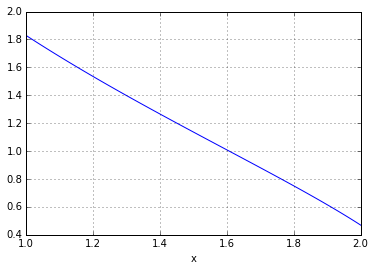

In [16]:
solver.solution['firm size'].plot()

# Example:

Multiplicative separability with log-normal worker skill and firm productivity distributions...

In [14]:
# define some workers skill
mu1, sigma1 = sym.var('mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'mu1': 0.0, 'sigma1': 1.0}
skill_bounds = [1e-3, 5e1]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some firms
mu2, sigma2 = sym.var('mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = [1e-3, 5e1]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

### Positive assortative matching

In [15]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for Cobb-Douglas between l and r
l, r, omega_B, sigma_B = sym.var('l, r, omega_B, sigma_B')
B = l**omega_B * r**(1 - omega_B)

F = A * B

F_params = {'omega_A':0.5, 'omega_B':0.45, 'sigma_A':0.5, 'sigma_B':1.0}

model = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = solvers.ShootingSolver(model=model)

In [16]:
solver.solve(5e-1, tol=1e-6, number_knots=5000, integrator='lsoda',
             with_jacobian=True, atol=1e-12, rtol=1e-9)

Exhausted firms: initial guess of 0.25 for firm size is too low.
Exhausted firms: initial guess of 0.375 for firm size is too low.


/Users/drpugh/anaconda/lib/python2.7/site-packages/scipy/integrate/_ode.py:1127: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  'Unexpected istate=%s' % istate))


In [43]:
solver.solution

,firm productivity,firm size,wage,profit
x,,,,
0.001000,0.001067,3.549875,0.000232,0.001005
0.051049,0.043892,1.585344,0.016516,0.032003
0.101098,0.086925,1.429779,0.034621,0.060501
0.151147,0.129960,1.345459,0.053521,0.088013
0.201196,0.172995,1.288533,0.072958,0.114900
0.251245,0.216032,1.245988,0.092806,0.141332
0.301294,0.259069,1.212244,0.112987,0.167405
0.351343,0.302107,1.184414,0.133450,0.193185
0.401392,0.345146,1.160814,0.154158,0.218716


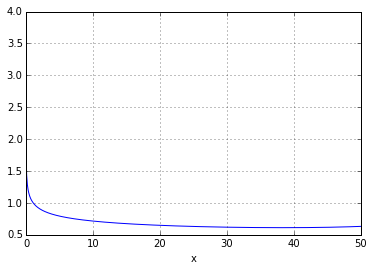

In [45]:
solver.solution['firm size'].plot()

### Negative assortative matching

In [197]:
F_params = {'omega_A':0.5, 'omega_B':0.45, 'sigma_A':1.5, 'sigma_B':1.0}

model = models.Model('negative',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = solvers.ShootingSolver(model=model)

In [198]:
solver.solve(1e3, tol=1e-6, number_knots=1000, atol=1e-12, rtol=1e-9)

Exhausted firms: initial guess of 500.0 for firm size is too low.
Exhausted workers: initial guess of 750.0 for firm size is too high!
Exhausted firms: initial guess of 625.0 for firm size is too low.
Exhausted firms: initial guess of 687.5 for firm size is too low.
Exhausted workers: initial guess of 718.75 for firm size is too high!
Exhausted workers: initial guess of 703.125 for firm size is too high!
Exhausted firms: initial guess of 695.3125 for firm size is too low.
Exhausted workers: initial guess of 699.21875 for firm size is too high!
Exhausted firms: initial guess of 697.265625 for firm size is too low.
Exhausted workers: initial guess of 698.2421875 for firm size is too high!
Exhausted workers: initial guess of 697.75390625 for firm size is too high!
Exhausted firms: initial guess of 697.509765625 for firm size is too low.
Exhausted workers: initial guess of 697.631835938 for firm size is too high!
Exhausted workers: initial guess of 697.570800781 for firm size is too high!


In [199]:
solver.solution

array([[  1.00000000e-04,   5.00000000e+01,   6.97520873e+02,
          7.96982563e-02,   6.79447968e+01],
       [  1.00200000e-01,   4.38421936e+01,   2.76462641e+02,
          1.62305818e-01,   5.48429383e+01],
       [  2.00300000e-01,   3.01915720e+01,   1.25086665e+02,
          1.99932868e-01,   3.05664771e+01],
       ..., 
       [  9.97998000e+01,   2.00562063e-02,   4.40863126e-04,
          4.66712075e+02,   2.51479732e-01],
       [  9.98999000e+01,   1.70657087e-02,   4.33023425e-04,
          4.67696609e+02,   2.47528829e-01],
       [  1.00000000e+02,   9.99753364e-04,   3.61574332e-04,
          4.68687387e+02,   2.07124291e-01]])

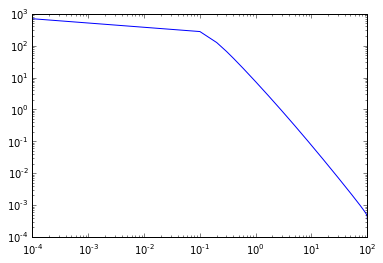

In [200]:
plt.plot(solver.solution[:, 0], solver.solution[:, 2])
plt.xscale('log')
plt.yscale('log')
plt.show()

# Example:

More sophisticated production function that is not multiplicatively separable...

In [106]:
# define some workers skill
x, mu1, sigma1 = sym.var('x, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'mu1': 0.0, 'sigma1': 1e0}
skill_bounds = [1e-3, 50.0]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some firms
y, mu2, sigma2 = sym.var('y, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'mu2': 0.0, 'sigma2': 1e0}
productivity_bounds = [1e-3, 50.0]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

# define some valid model params
F_params = {'eta': 0.89, 'kappa': 1.0, 'gamma': 0.54, 'rho': 0.24, 'A': 1.0, 'k': 1.0}

# define a valid production function
A, k, kappa, eta, rho, l, gamma, r = sym.var('A, k, kappa, eta, rho, l, gamma, r')
F = r * A * kappa * eta * ((k * x)**rho + (1 - eta) * (y * (l / r))**rho)**(gamma / rho)

model = models.Model('negative',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

In [108]:
solver = solvers.ShootingSolver(model=model)

In [109]:
solver.solve(1e0, tol=1e-4, number_knots=10000, integrator='vode',
             atol=1e-9, rtol=1e-6, check=True)

Exhausted firms: initial guess of 0.5 for firm size is too low.


In [110]:
solver.integrator.successful()

False

In [111]:
solver._solution

array([[  1.00000000e-03,   5.00000000e+01,   7.50000000e-01,
          6.25292214e-02,   1.02985470e-01],
       [  6.00040004e-03,   4.91355141e+01,   2.93698995e-02,
          6.50895813e-01,   1.02614135e-01],
       [  1.10008001e-02,   1.87728995e+01,   6.10881218e-04,
          8.73207163e+00,   9.34543423e-02],
       [  1.34286568e-02,   2.61227847e+06,   1.98653860e+04,
          1.04151668e-01,   1.79568793e+03]])

In [46]:
integrat

50.0